In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Argon Physical Properties
rho = 1.633             #[kg/m^3]  Density
C = 520                 #[J/kg-K]  Specific Heat Capacit
alpha = 2.2e-5          #[m^2/s]   Thermal diffusivity
mu = 3.77e-5            # Dynamic viscosity

# nu is to small to run on our resources/requires a timestep that is to small
#nu = mu/rho             # [Pa-s]
nu = 0.1

# Inlet velocity
u_inlet = 4             # [m/s]

# Using relative to ambient pressure
# p_ambient = 101325
p_ambient = 101325      # [Pa]
p_outlet = p_ambient


#Meshing
Lx = 0.4       #[m]
Ly = 0.4       #[m]
dx = 0.01     #[m]
dy = 0.01     #[m]
dt = 0.0001   #[s] ?Higher timestep might be usable
t_max = 1     #[s]
x = np.arange(0, Lx+dx, dx)
Nx = len(x) - 1
y = np.arange(0, Ly+dy, dy)
Ny = len(y) - 1
t = np.arange(0, t_max+dt, dt)
num_timesteps = int(len(t) - 1)
# Inlet
inlet_height = 0.0
inlet_size = 0.1
outlet_height = 0.26
outlet_size = 0.1

inlet_start = int(inlet_height/dy)
print(inlet_start)
inlet_end = int((inlet_height+inlet_size)/dy)+1
print(inlet_end)

outlet_start = int(outlet_height/dy)
print(outlet_start)
outlet_end = int((outlet_height+outlet_size)/dy)+1
print(outlet_end)

tol = 1e-5

print('Number of points (x-direction): {0:2d} '.format(Nx+1))
print('Number of points (y-direction): {0:2d} '.format(Ny+1))
print('Mesh size (dx): {0:.8f} mm'.format(dx))
print('Mesh size (dy): {0:.8f} mm'.format(dy))
print('Number of time steps: {0:2d} '.format(num_timesteps))
print('Time step (dt): {0:.8f} s'.format(dt))

0
11
26
37
Number of points (x-direction): 41 
Number of points (y-direction): 41 
Mesh size (dx): 0.01000000 mm
Mesh size (dy): 0.01000000 mm
Number of time steps: 10000 
Time step (dt): 0.00010000 s


# Navier Stokes Solver
Whichever solver parameters we finally decide on will go here

In [3]:

def solver(inlet_start, outlet_start, u_inlet, p_outlet, dx, dy, dt, Nx, Ny, nu, rho, steps):
  u = np.zeros((Nx+2, Ny+2))
  v = np.zeros((Nx+2, Ny+2)) # Apply boundary condition on index Nx-1
  p = np.ones((Nx+2, Ny+2))*p_ambient

  u[0,inlet_start:inlet_end] = u_inlet
  for n in range(steps):

    # A (Convective term)
    A_u = -((((u[1:-1,1:-1] + u[2:,1:-1])/2)**2
              - ((u[1:-1,1:-1] + u[0:-2,1:-1])/2)**2)/dx
              + (((u[1:-1,2:] + u[1:-1,1:-1])/2)*((v[2:,1:-1] + v[1:-1,1:-1])/2)
              - ((u[1:-1,1:-1] + u[1:-1,:-2])/2)*((v[1:-1,0:-2] + v[2:,0:-2])/2))/dy)
    A_v = -((((v[1:-1,1:-1] + v[2:,1:-1])/2)*((u[1:-1,1:-1] + u[1:-1,:-2])/2)
              - ((v[1:-1,1:-1] + v[:-2,1:-1])/2)*((u[0:-2,2:] + u[0:-2,1:-1])/2))/dx
              + (((v[1:-1,1:-1] + v[1:-1,2:])/2)**2
              - ((v[1:-1,1:-1] + v[1:-1,0:-2])/2)**2)/dy)

    # B (Diffusion term)
    B_u = nu*((u[2:,1:-1] - 2*u[1:-1,1:-1] + u[0:-2,1:-1])/dx**2)
    B_v = nu*((v[1:-1,2:] - 2*v[1:-1,1:-1] + v[1:-1,0:-2])/dy**2)

    # Step 1 - Compute u_temp and v_temp (u* in the discretization)
    u_temp = np.zeros_like(u)
    v_temp = np.zeros_like(v)
    u_temp[1:-1, 1:-1] = u[1:-1, 1:-1] + dt*(A_u + B_u)
    v_temp[1:-1, 1:-1] = v[1:-1, 1:-1] + dt*(A_v + B_v)

    # Boundary conditions on u* and v*

    # Right wall
    # Outlet boundary condition
    u_temp[-2,:outlet_start] = 0
    u_temp[-1,outlet_start:outlet_end] = u_temp[-2,outlet_start:outlet_end]
    u_temp[-2,outlet_end:] = 0
    v_temp[-1,:] = - v_temp[-2,:]
    v_temp[-1,outlet_start:outlet_end] = v_temp[-2,outlet_start:outlet_end]

    # Left wall
    u_temp[0,:] = 0
    # Inlet boundary condition
    u_temp[0,inlet_start:inlet_end] = u_inlet
    v_temp[0,:] = - v_temp[1,:]

    # Bottom wall
    u_temp[:,0] = - u_temp[:,1]
    v_temp[:,0] = 0

    # Top wall
    u_temp[:,-1] = - u_temp[:,-2]
    v_temp[:,-1] = 0
    v_temp[:,-2] = 0

    # Step 2 - Poisson iterative solver for p(n+1)
    error = 1
    iteration = 0

    p_ref = p.copy()
    while error > tol:
        p[:,-2] = p[:,-1]
        p[1,:] = p[0,:]
        p[:,1] = p[:,0]
        # Outlet pressure boundary conditions
        p[-2,:outlet_start] = p[-1,:outlet_start]
        p[-2,outlet_start:outlet_end] = 2*p_outlet - p[-1,outlet_start:outlet_end]
        p[-2,outlet_end:] = p[-1,outlet_end:]
        #p[-1,outlet_start:outlet_end] = p[-2,outlet_start:outlet_end] - 20

        p[1:-1,1:-1] = (p_ref[:-2,1:-1] + p_ref[2:,1:-1] + p_ref[1:-1,:-2] + p_ref[1:-1,2:])/4 - ((dx**2*rho)/(4*dt))*(((u_temp[1:-1,1:-1] - u_temp[:-2,1:-1])/(dx)) + ((v_temp[1:-1,1:-1] - v_temp[1:-1,0:-2])/(dy)))
        p[:,0] = p[:,1]   # Bottom wall
        p[:,-1] = p[:,-2] # Top wall
        p[0,:] = p[1,:]   # Left wall

        #p[-1,:] = p[-2,:] # Right wall

        #p[-1,outlet_start:outlet_end] = p_outlet
        # Outlet pressure boundary conditions
        p[-1,:outlet_start] = p[-2,:outlet_start]
        p[-1,outlet_start:outlet_end] = 2*p_outlet - p[-2,outlet_start:outlet_end]
        p[-1,outlet_end:] = p[-2,outlet_end:]
        #p[-1,outlet_start:outlet_end] = p[-2,outlet_start:outlet_end] - 20

        error =  np.linalg.norm(p-p_ref)
        iteration += 1
        if iteration >= 100000:
          print(f"PJ Solver was aborted after 100000 iterations with a remaining error of {error}")
          break
        p_ref = p.copy()


    # Compute u(n+1) and v(n+1)
    u[1:-1,1:-1] = u_temp[1:-1,1:-1] - (dt/rho)*((p[2:,1:-1] - p[1:-1,1:-1])/(dx))
    v[1:-1,1:-1] = v_temp[1:-1,1:-1] - (dt/rho)*((p[1:-1,2:] - p[1:-1,1:-1])/(dy))

    # Right wall
    u[-2,:outlet_start] = 0
    u[-1,outlet_start:outlet_end] = u[-2,outlet_start:outlet_end]
    u[-2,outlet_end:] = 0
    v[-1,:] = - v[-2,:]
    v[-1,outlet_start:outlet_end] = v[-2,outlet_start:outlet_end]

    # Left wall
    u[0,:] = 0
    u[0,inlet_start:inlet_end] = u_inlet
    v[0,:] = - v[1,:]

    # Bottom wall
    u[:,0] = - u[:,1]
    v[:,0] = 0

    # Top wall
    u[:,-1] = - u[:,-2]
    v[:,-1] = 0
    v[:,-2] = 0

  return u, v, p


In [4]:
def plot_results(u,v,p):
    xx, yy = np.meshgrid(x,y)

    u_plot = (u[:-1,1:] + u[:-1,:-1])/2
    v_plot = (v[1:,:-1] + v[:-1,:-1])/2
    p_plot = (p[:-1, :-1] + p[1:, :-1] + p[:-1, 1:] + p[1:, 1:])/4


    plt.streamplot(xx,yy,u_plot.T, v_plot.T, color=np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T),density=1.5,linewidth=1.5, cmap=plt.cm.viridis)
    plt.colorbar(label = 'Velocity [m/s]')
    plt.xlabel('x [m]',fontsize = 14 )
    plt.ylabel('y [m]',fontsize = 14 )
    plt.title('Streamlines', fontsize = 14)
    plt.tick_params(labelsize=12)
    plt.ylim([0,0.4])
    plt.xlim([0,0.4])
    plt.show()


    plt.quiver(xx, yy, u_plot.T, v_plot.T,np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T))
    plt.colorbar(label = 'Velocity [m/s]')
    plt.xlabel('x [m]',fontsize = 14 )
    plt.ylabel('y [m]',fontsize = 14 )
    plt.title('Velocity vectors', fontsize = 14)
    plt.tick_params(labelsize=12)
    plt.ylim([0,0.4])
    plt.xlim([0,0.4])
    plt.show()

    plt.contourf(xx, yy, np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T), levels = 100, cmap = 'jet')
    plt.colorbar(label = 'Velocity [m/s]')
    plt.xlabel('x [m]',fontsize = 14 )
    plt.ylabel('y [m]',fontsize = 14 )
    plt.title('Velocity contour', fontsize = 14)
    plt.tick_params(labelsize=12)
    plt.ylim([0,0.4])
    plt.xlim([0,0.4])
    plt.show()


    plt.contourf(xx, yy, p_plot.T, levels = 100, cmap = 'jet')
    plt.colorbar(label = 'Pressure [Pa]')
    plt.xlabel('x [m]',fontsize = 14 )
    plt.ylabel('y [m]',fontsize = 14 )
    plt.title('Pressure contour', fontsize = 14)
    plt.tick_params(labelsize=12)
    plt.ylim([0,0.4])
    plt.xlim([0,0.4])
    plt.tight_layout()
    plt.show()
    return


# Temperature solver
Returns temperature for given u and v

In [5]:
def temp_solver(u, v, plotter):
  
  # Calculate averages
  u_plot = (u[:-1,1:] + u[:-1,:-1])/2
  v_plot = (v[1:,:-1] + v[:-1,:-1])/2

  u = u_plot.copy()
  v = v_plot.copy()

  # Initialize temperature field
  T = np.ones([Nx + 1, Ny + 1])*373.15
  T_ref = T.copy()

  q = 0.25
  # Calculate position of build plate
  lba = .254
  build_start = 0.073
  plate_start = int(build_start/dx)
  plate_end = int((build_start + lba)/dx)
  dt = 0.0001
  for n in range(int(1/dt)):                              #range(int(0.18/dt)):
    
    # Initialize upwind contribution matrices
    upwind_x = np.zeros([Nx + 1, Ny + 1])
    upwind_y = np.zeros([Nx + 1, Ny + 1])

    # Compute upwind scheme in x and y direction
    upwind_x[2:-2, 2:-2] = np.minimum(u[2:-2, 2:-2], 0) *\
              (T_ref[:-4, 2:-2] - 3 * T_ref[1:-3, 2:-2] + 3 * T_ref[2:-2, 2:-2] - T_ref[3:-1, 2:-2]) / (3 * dx) \
                        + np.maximum(u[2:-2, 2:-2], 0) * \
              (-T_ref[4:, 2:-2] + T_ref[1:-3, 2:-2] - 3 * T_ref[2:-2, 2:-2] + 3 * T_ref[3:-1, 2:-2]) / (3 * dx)

    upwind_y[2:-2, 2:-2] = np.minimum(v[2:-2, 2:-2], 0) * \
              (T_ref[2:-2, :-4] - 3 * T_ref[2:-2, 1:-3] + 3 * T_ref[2:-2, 2:-2] - T_ref[2:-2, 3:-1]) / (3 * dy) \
                        + np.maximum(v[2:-2, 2:-2], 0) * \
              (-T_ref[2:-2, 4:] + T_ref[2:-2, 1:-3] - 3 * T_ref[2:-2, 2:-2] + 3 * T_ref[2:-2, 1:-3]) / (3 * dy)

    # Compute new Temperature field using blended scheme
    T[1:-1, 1:-1] = T_ref[1:-1, 1:-1] + dt * \
                  (-u[1:-1, 1:-1]* (T_ref[2:, 1:-1] - T_ref[:-2, 1:-1]) / 2.0 / dy
                  + q * upwind_x[1:-1, 1:-1]
                  + (T_ref[1:-1, 2:] - T_ref[1:-1, :-2]) / 2.0 / dy * -v[1:-1, 1:-1]
                  + q * upwind_y[1:-1, 1:-1]
                  + nu * ((T_ref[:-2, 1:-1] - 2.0 * T_ref[1:-1, 1:-1] + T_ref[2:, 1:-1]) / dx / dx
                        + (T_ref[1:-1, :-2] - 2.0 * T_ref[1:-1, 1:-1] + T_ref[1:-1, 2:]) / dy / dy))
    # Neumann dT/dx = 0
    T[:,0] = T[:,1]
    T[:,-1] = T[:,-2]
    T[0,:] = T[1,:]
    T[-1,:] = T[-2,:]
    # Apply boundary conditions

    # Inlet position and temperature
    T[0, inlet_start:inlet_end] = 350

    T[plate_start:plate_end, 0] = 473
    # Melt point in the middle
    T[21,0] = 1700

    T_ref = T.copy()


  if plotter == True:
    xx, yy = np.meshgrid(x,y)
    plt.contourf(xx, yy, T.T, levels = 1000, cmap = 'jet', vmax=600)
    plt.colorbar(label = 'Temperature [K]', ticks=range(350,650,50)).ax.set_ylim(350, 600)
    plt.xlabel('x [m]',fontsize = 14 )
    plt.ylabel('y [m]',fontsize = 14 )
    plt.title('Temperature contours', fontsize = 14)
    plt.tick_params(labelsize=12)
    plt.ylim([0,0.4])
    plt.xlim([0,0.4])
    plt.show()

  return(T)




# Splits problem into batches
Solves for u, v, and T by calling previous functions

In [6]:
def batch_solver(num_timesteps, num_batches, inlet_start, outlet_start, u_inlet, p_outlet, dx, dy, dt, Nx, Ny, nu, rho, plotter):
  for i in range(num_batches):
    u, v, p = solver(inlet_start, outlet_start, u_inlet, p_outlet, dx, dy, dt, Nx, Ny, nu, rho, num_timesteps)
    if plotter:
      plot_results(u, v, p)
    T = temp_solver(u,v, plotter)
  return u, v, p, T

# Calculates position of inlet and outlet

In [7]:
def calculate_inlets(inlet_height, outlet_height):
  inlet_start = int(inlet_height/dy)
  inlet_end = int((inlet_height+inlet_size)/dy)+1

  outlet_start = int(outlet_height/dy)
  outlet_end = int((outlet_height+outlet_size)/dy)+1
  return inlet_start, inlet_end, outlet_start, outlet_end

# Finds mean temperature and speed

In [8]:
def mean(T_temp, area_start_x, area_end_x, area_start_y, area_end_y):
    T_area = T_temp[area_start_x:area_end_x, area_start_y:area_end_y]
    T_test = np.ones_like(T_area)*473
    error = np.mean((T_area))
    return error

# Finds temperature homogeneity

In [9]:
def std_dev(T_temp, area_start_x, area_end_x, area_start_y, area_end_y):
    T_area = T_temp[area_start_x:area_end_x, area_start_y:area_end_y]
    T_test = np.ones_like(T_area)*473
    error = np.std((T_area))
    return error

# Case exploration parameters
1. Define region of interest around build plate
2. Starting heights for inlet and outlet
3. Increment for test cases
4. Number of batches to run for each test case
5. Number of timesteps per batch




In [10]:
# Define region of interest for mean and standard deviation calculation
area_start_x = int(Nx/4)
area_end_x = int(3*Nx/4+1)
area_start_y = 1
area_end_y = int(Ny/3+1)

starting_height = 0 # Starting heights
inlet_height = starting_height
outlet_height = 0.28
test_range = 0.04 # Range of heights to test
increment = 0.02 # Amount to increase height by
num_batches = 1
num_timesteps = int(1/dt)
num_cases = int(test_range/increment) # Number of test cases
u_storage = np.zeros((num_cases, num_cases, Nx+2, Ny+2)) # Holds us from all cases
v_storage = np.zeros((num_cases, num_cases, Nx+2, Ny+2))# Holds vs from all cases
T_storage = np.zeros((num_cases, num_cases, Nx+2, Ny+2)) # Holds Ts from all cases
P_storage = np.zeros((num_cases, num_cases, Nx+2, Ny+2)) # Holds Ts from all cases
T_averages = np.zeros((num_cases, num_cases)) # Holds T averages in area of interest from all cases
T_stddev = np.zeros((num_cases, num_cases))# Holds T stddevs in area of interest from all cases
u_averages = np.zeros((num_cases, num_cases)) # Holds u averages in area of interest from all cases
v_averages = np.zeros((num_cases, num_cases)) # Holds v averages in area of interest from all cases


print(np.shape(u_storage))
print(np.shape(T_storage))
print(np.shape(P_storage))

(2, 2, 42, 42)
(2, 2, 41, 41)
(2, 2, 42, 42)


# Scoring Parameters
Coefficients for scoring the cases. This is subjective and will count on how we want to weight different factors. I've included the relevant function directly below to show how this will work.

In [11]:
# Score the cases
scores = np.zeros((num_cases, num_cases)) # stores the scores

# Reward function coefficients:
T_homogeneity = 0.1 # T standard deviation multiplier
T_value = 0.1 # T average multiplier
speed_value = 0.1 # Mutliplier of Average of norm of u and v

In [12]:
def score(u, v, T_avg, T_sd):
  s = -T_homogeneity*T_sd + (T_value/100)*T_avg + speed_value*((u**2 + v**2)**(-1/2))
  return s

# Case Exploration
Runs through test cases based on case exploration parameters. Stores u, v, and T values for the whole domain and takes relevant metrics for the area around the build plate. Scores each test case based on previously defined coefficients.

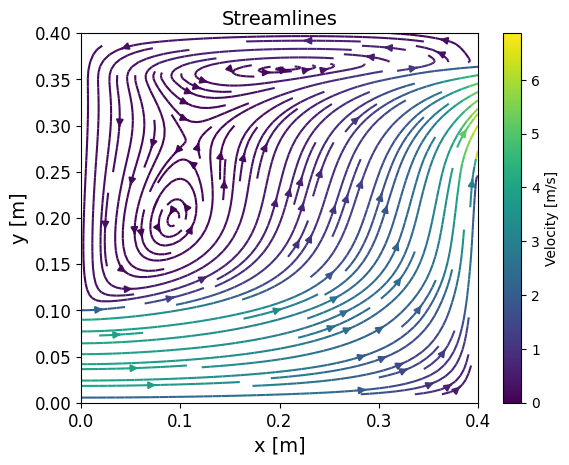

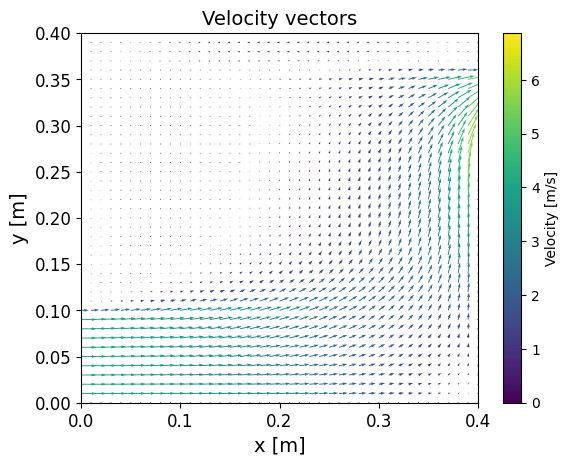

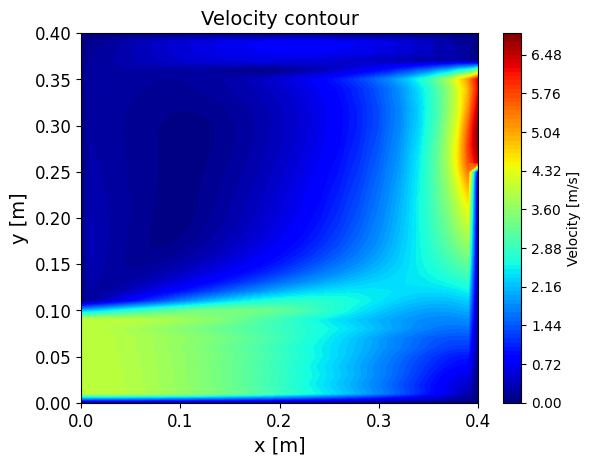

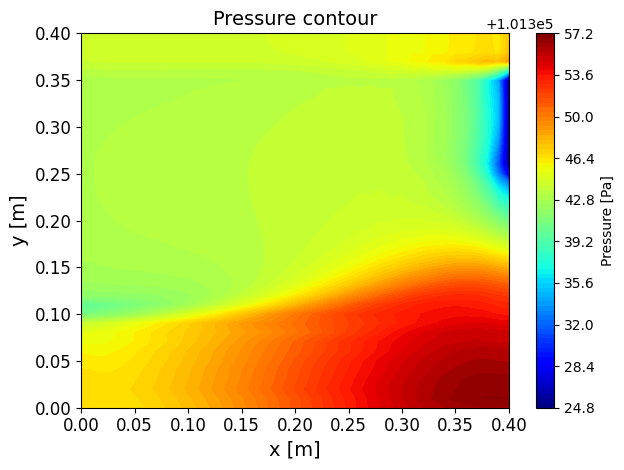

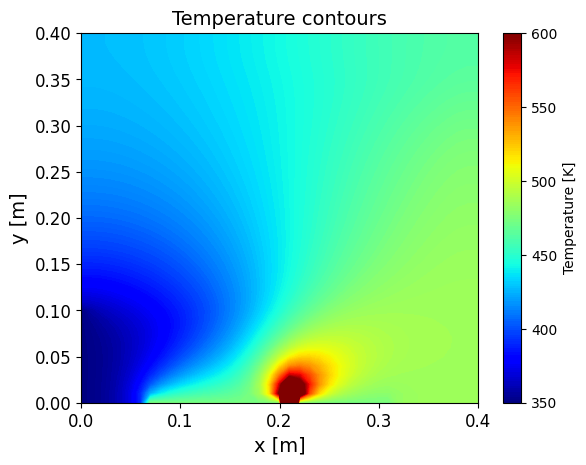

ValueError: could not broadcast input array from shape (42,42) into shape (41,41)

In [13]:
plotter = True # Make false if you don't want plots to be generated while this runs. Remember we can always plot the stored values later
for i in range(num_cases):
  inlet_height = starting_height
  for j in range(num_cases):
    inlet_start, inlet_end, outlet_start, outlet_end = calculate_inlets(inlet_height, outlet_height)
    u_storage[i, j], v_storage[i, j], T_storage[i, j], P_storage[i, j] = batch_solver(num_timesteps, num_batches, inlet_start, outlet_start, u_inlet, \
                                                                     p_outlet, dx, dy, dt, Nx, Ny, nu, rho, plotter)
    u_averages[i, j] = mean(u_storage[i, j], area_start_x, area_end_x, area_start_y, area_end_y)
    v_averages[i, j] = mean(v_storage[i, j], area_start_x, area_end_x, area_start_y, area_end_y)
    T_averages[i, j] = mean(T_storage[i, j], area_start_x, area_end_x, area_start_y, area_end_y)
    T_stddev[i, j] = std_dev(v_storage[i, j], area_start_x, area_end_x, area_start_y, area_end_y)

    scores[i,j] = score(u_averages[i, j], v_averages[i, j], T_averages[i, j],  T_stddev[i, j])

    inlet_height += increment
  outlet_height += increment

In [16]:
np.save("u1-1.npy", u_storage[0,0])
np.save("v1-1.npy", v_storage[0,0])
np.save("T1-1.npy", T_storage[0,0])
np.save("P1-1.npy", P_storage[0,0])

In [ ]:
print(scores)
np.save("u_storage.npy", u_storage)
np.save("v_storage.npy", v_storage)
np.save("T_storage.npy", T_storage)
np.save("P_storage.npy", P_storage)
np.save("u_averages.npy", u_averages)
np.save("v_averages.npy", v_averages)
np.save("T_averages.npy", T_averages)
np.save("T_stddev.npy", T_stddev)
np.save("scores.npy", scores)

# Plot cases on contour plot

In [ ]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.rcParams["xtick.labelbottom"]  = False
plt.rcParams['xtick.labeltop'] = True
# plot the matrix as an image with an appropriate colormap
plt.imshow(T_averages, aspect='auto', cmap="Reds")

# add the values
for (i, j), value in np.ndenumerate(T_averages.T):
    plt.text(i, j, "%.3f"%value, va='center', ha='center')
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.xticks([0, 1, 2, 3], ['0.0', '0.1', '0.2', "0.3"])
plt.yticks([0, 1, 2, 3], ['0.0', '0.1', '0.2', "0.3"])
plt.rcParams["xtick.labelbottom"]  = False
plt.rcParams['xtick.labeltop'] = True
plt.xlabel("Inlet height (m)")
plt.ylabel("Outlet height (m)")
plt.title("Average Temperature Around Build Plate (K)")

plt.tight_layout
plt.show()

In [ ]:
T_averages[0,3]

In [ ]:
twos = np.ones_like(u_averages)*2
halves = np.ones_like(u_averages)*0.5

speed = np.power((np.power(u_averages, twos) + np.power(u_averages, twos)), halves)

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.rcParams["xtick.labelbottom"]  = False
plt.rcParams['xtick.labeltop'] = True
# plot the matrix as an image with an appropriate colormap
plt.imshow(speed, aspect='auto', cmap="Blues")

# add the values
for (i, j), value in np.ndenumerate(speed.T):
    plt.text(i, j, "%.3f"%value, va='center', ha='center')
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.xticks([0, 1, 2, 3], ['0.0', '0.1', '0.2', "0.3"])
plt.yticks([0, 1, 2, 3], ['0.0', '0.1', '0.2', "0.3"])
plt.rcParams["xtick.labelbottom"]  = False
plt.rcParams['xtick.labeltop'] = True
plt.xlabel("Inlet height (m)")
plt.ylabel("Outlet height (m)")
plt.title("Average Gas Speed Around Build Plate (m/s)")

plt.tight_layout
plt.show()

In [ ]:
print(speed[3,0])

In [ ]:
twos = np.ones_like(u_averages)*2
halves = np.ones_like(u_averages)*0.5

speed = np.power((np.power(u_averages, twos) + np.power(u_averages, twos)), halves)

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.rcParams["xtick.labelbottom"]  = False
plt.rcParams['xtick.labeltop'] = True
# plot the matrix as an image with an appropriate colormap
plt.imshow(T_stddev, aspect='auto', cmap="Greens")

# add the values
for (i, j), value in np.ndenumerate(T_stddev.T):
    plt.text(i, j, "%.3f"%value, va='center', ha='center')
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.xticks([0, 1, 2, 3], ['0.0', '0.1', '0.2', "0.3"])
plt.yticks([0, 1, 2, 3], ['0.0', '0.1', '0.2', "0.3"])
plt.rcParams["xtick.labelbottom"]  = False
plt.rcParams['xtick.labeltop'] = True
plt.xlabel("Inlet height (m)")
plt.ylabel("Outlet height (m)")
plt.title("Temperature Standard Deviation Build Plate (K)")

plt.tight_layout
plt.show()